# Data Quality Assesment
- accuracy
- completeness
- consistency
- currency
- relevancy
- validaty
- uniqueness

For these 3 datasets:
- the empty values
- inconsistent customer_id in 3 datasets
- inconsistent values for the same attribute, such as the 'state','gender'
- inconsistent data types
- wrong values, such as DOB

In [85]:
# import necessary library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set()

In [2]:
# customer dataset: main train datasets
customer = pd.read_excel('/KPMG/customer_edited.xlsx',sheet_name='CustomerDemographic',skiprows=1)

# basic insight and data checking
customer.head()
customer.info()
customer.isnull().sum()

# delete the wrong DOB
customer.replace(customer['DOB'].min(),np.nan,inplace=True)
# gender & DOB & tenure: consistent trends
customer['gender'].replace(['F','Femal','M'],['Female','Female','Male'],inplace=True)
# dropna where gender & DOB & tenure is nan: DOB=nan,gender=U
customer.dropna(subset=['DOB'],inplace=True)
# or impute data where gender & DOB & tenure is nan by the distribution,but i don't know how to do
# drop values where deceased_indicator == Yes
customer.drop(customer[customer['deceased_indicator'] == 'Y'].index,axis=0,inplace=True)
# delete default column
customer.drop(['default'],axis=1,inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          4000 non-null   int64         
 1   first_name                           4000 non-null   object        
 2   last_name                            3875 non-null   object        
 3   gender                               4000 non-null   object        
 4   past_3_years_bike_related_purchases  4000 non-null   int64         
 5   DOB                                  3913 non-null   datetime64[ns]
 6   job_title                            3494 non-null   object        
 7   job_industry_category                3344 non-null   object        
 8   wealth_segment                       4000 non-null   object        
 9   deceased_indicator                   4000 non-null   object        
 10  default     

In [3]:
# address dataset
address = pd.read_excel('/KPMG/customer_edited.xlsx',sheet_name='CustomerAddress',skiprows=1)

# basic insight and data checking
address.head()
address.info()
address.isnull().sum()
address['state'].replace(['New South Wales','Victoria'],['NSW','VIC'],inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         3999 non-null   int64 
 1   address             3999 non-null   object
 2   postcode            3999 non-null   int64 
 3   state               3999 non-null   object
 4   country             3999 non-null   object
 5   property_valuation  3999 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 187.6+ KB


In [4]:
# transactions dataset: label datesets
transactions = pd.read_excel('/KPMG/customer_edited.xlsx',sheet_name='Transactions',skiprows=1)

# basic insight and data checking
transactions.head()
transactions.info()
transactions.isnull().sum()
# standard_cost 成本
transactions.dropna(subset=['standard_cost'],axis=0,inplace=True) 
# band, product_line, product_class, product_size - consistent with standard_costs(if standard_costs is null, then they are null)
# data astype for product_first_sold_date
transactions['product_first_sold_date'] = pd.to_datetime(transactions['product_first_sold_date']-2,unit='D',origin=pd.Timestamp('1900-01-01')) # the reason for -2: excel origin date from 1900-01-01(day1),but in mac, day1 is 1900/01/02;in mac, no 1900/02/29(mac origin date from 1904)
# delete transactions order_status = cancelled
transactions.drop(transactions[transactions['order_status'] == 'Cancelled'].index,axis=0,inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

# Data Exploration

We use the datasets with: live(deceased_indicator=N) and having approved transactions(no cancelled) customers, no empty values

Approach plan: understanding the data distributions, feature engineering, data transformations, modelling, results interpretation and reporting

- data transformation
- variable distribution
- external data
- variable interaction

## Data transformation

In [5]:
# customer dataset
# DOB transfered to age
import datetime
customer['age'] = datetime.datetime.now().year - customer['DOB'].dt.year
# age grouped
age_bins = pd.IntervalIndex.from_tuples([(0,20),(20,30),(30,40),(40,50),(50,60),(60,70),(70,90)])
customer['age_grouped'] = pd.cut(customer['age'],age_bins)
# wealth segment
customer['wealth'] = customer['wealth_segment'].replace(['Mass Customer','Affluent Customer','High Net Worth'],[1,2,3])

# address dataset 
# postcode transformation
postcode = pd.read_csv('/KPMG/australian_postcodes.csv')
# Labour markets were a key consideration in the design of SA4s
postcode=postcode[['postcode','sa3name','sa4name']]
postcode.drop_duplicates(inplace=True)
postcode.dropna(axis=0,inplace=True)
new_address = address.merge(postcode,how='left',on='postcode')

# transaction dataset
# add two columns:recency and profit(high profit:high margin product)
transactions['recency'] = (transactions['transaction_date'].max() - transactions['transaction_date']).dt.days
transactions['profit'] = transactions['list_price'] - transactions['standard_cost']

# Merge customer&address datasets
new_customer = customer.merge(new_address,how='left',on='customer_id')
new_customer.dropna(subset=['postcode'],axis=0,inplace=True)

In [6]:
# consistent with the customer_id in new_customer and transaction datasets
customer_customer_id = new_customer['customer_id'].unique()
trans_customer_id = transactions['customer_id'].unique()

for i in range(len(customer_customer_id)):
    if customer_customer_id[i] not in trans_customer_id:
        new_customer.drop(new_customer[new_customer['customer_id']==customer_customer_id[i]].index,axis=0,inplace=True)

for j in range(len(trans_customer_id)):
    if trans_customer_id[j] not in customer_customer_id:
        transactions.drop(transactions[transactions['customer_id']==trans_customer_id[j]].index,inplace=True)

In [7]:
# merge customer demographic with their numbers of transaction,latest recency and average profit
df_trans = pd.DataFrame()
df_trans['trans_count'] = transactions.groupby(['customer_id'])['transaction_id'].count()
df_trans['min_recency'] = transactions.groupby(['customer_id'])['recency'].min()
df_trans['avg_profit'] = transactions.groupby(['customer_id'])['profit'].mean()
df_trans.reset_index(inplace=True)

new_customer = new_customer.merge(df_trans, how='left',on='customer_id')
# new_customer.set_index('customer_id',inplace=True)
new_customer.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,address,postcode,state,country,property_valuation,sa3name,sa4name,trans_count,min_recency,avg_profit
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,060 Morning Avenue,2016.0,NSW,Australia,10.0,Sydney Inner City,Sydney - City and Inner South,11,7,274.371818
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,...,6 Meadow Vale Court,2153.0,NSW,Australia,10.0,Parramatta,Sydney - Parramatta,3,128,742.086667
2,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,...,0 Holy Cross Court,4211.0,QLD,Australia,9.0,Robina,Gold Coast,2,195,110.285000
3,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,...,17979 Del Mar Point,2448.0,NSW,Australia,4.0,Kempsey - Nambucca,Mid North Coast,6,16,399.156667
4,6,Curr,Duckhouse,Male,35,1966-09-16,NaN,Retail,High Net Worth,N,...,9 Oakridge Court,3216.0,VIC,Australia,9.0,Surf Coast - Bellarine Peninsula,Geelong,5,64,789.310000


## Variable distribution

### gender & age & tenure

female:  1756 0.51
male:  1654 0.49
age below or equal 50:  2446 0.72
gender
Female    10.67
Male      10.69
Name: tenure, dtype: float64
the average of tenure for age above 30 is:  12.23
the average of tenure for age below or equal to 30 is:  4.32


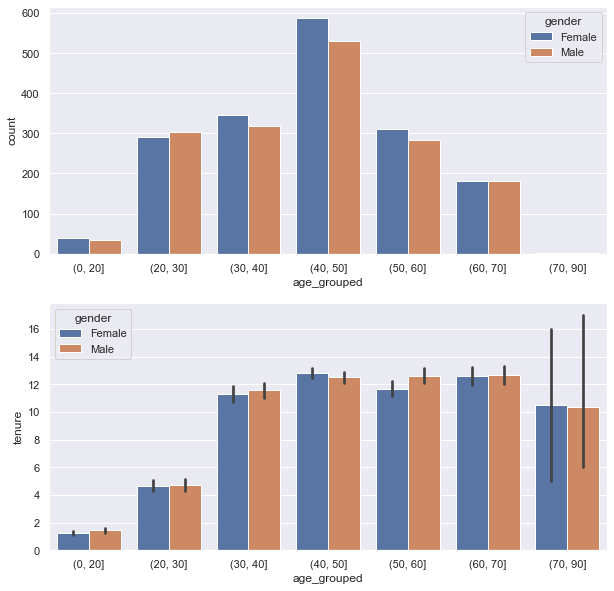

In [8]:
# gender & age & tenure
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.countplot(new_customer['age_grouped'],hue=new_customer['gender'])
plt.subplot(2,1,2)
sns.barplot(x='age_grouped',y='tenure',hue='gender',data=new_customer)
# gender ratio
female = len(new_customer[new_customer['gender']=='Female'])
print('female: ',female,round(female/len(new_customer),2))
print('male: ',len(new_customer)-female,1-round(female/len(new_customer),2))
# age ratio
age_below50 = len(new_customer[new_customer['age']<51])
print('age below or equal 50: ',age_below50,round(age_below50/len(new_customer),2))
# tenure
gender_tenure = round(new_customer.groupby(['gender'])['tenure'].mean(),2)
age_above30 = new_customer[new_customer['age']>30]['tenure'].mean()
age_below30 = new_customer[new_customer['age']<31]['tenure'].mean()
print(gender_tenure)
print('the average of tenure for age above 30 is: ',round(age_above30,2))
print('the average of tenure for age below or equal to 30 is: ',round(age_below30,2))

results: 
1. The number of female is slightly higher than the number of male.
2. About 72% of customers are below or equal to 50, which means the distribution of age is skewes and more customers are younger.
3. The average of tenure between gender is similar.
4. The customers with age>30 have similar and longer tenure, whose average of tenure is about 3 times than other customers(age<=30).

### past_3_years_bike_related_purchases

In [9]:
# past_3_years_bike_related_purchases
bought_bins = pd.IntervalIndex.from_tuples([(0,20),(20,40),(40,60),(60,80),(80,100)])
new_customer['bought_grouped'] = pd.cut(new_customer['past_3_years_bike_related_purchases'],bought_bins)
print(new_customer.groupby(['bought_grouped']).agg({'customer_id':'count','trans_count':'sum','avg_profit':'median'}))

                customer_id  trans_count  avg_profit
bought_grouped                                      
(0, 20]                 703         3952  525.813333
(20, 40]                708         3933  510.570083
(40, 60]                672         3831  521.279429
(60, 80]                687         3863  548.733333
(80, 100]               607         3381  546.541111


results:
1. The customers who bought bike in groups of (0,20] and (20,40] are slightly more than other groups, and they also had more transactions in the last year.
2. The customers who bought bike in groups of (60,80] and (80,100] have higher median of avg_profit.

### job_industry_category

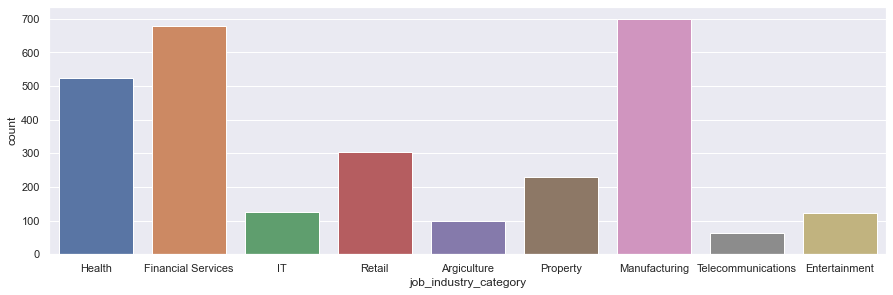

In [10]:
# job_industry_category
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.countplot(new_customer['job_industry_category'])

results:

1. The customers are mainly employeed in manufacturing, financial services, and health industry.

### wealth_segment

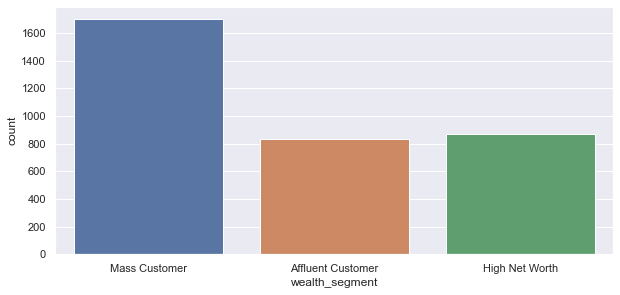

In [11]:
# wealth_segment
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.countplot(new_customer['wealth_segment'])

results:
1. The customers are mainly mass customer, about twice times than other segments.
2. The numbers of affluent_customer and high net worth customer are similar.

(high net worth > affluent customer > mass customer)

"high-net-worth individual" is a person with at least 1 million dollars.

Affluent consumers – those with net wealth between 100000 and 1 million dollars across the entire income spectrum – make up an important consumer group, but they are not fully understood nor effectively targeted by businesses.

### owns_car

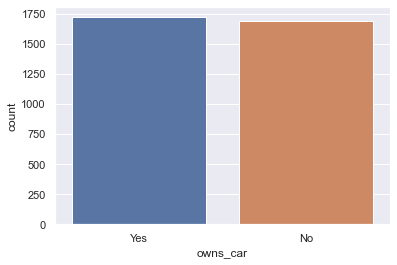

In [13]:
# owns_car
sns.countplot(new_customer['owns_car'])

results:
1. The number of customers with is slightly more than those without cars.

### state & sa4name

Top5 most trans_count places: 
                                   trans_count
sa4name                                       
Sydney - South West                        148
Sydney - North Sydney and Hornsby          136
Sydney - Blacktown                         133
Sydney - Parramatta                        128
Sydney - Inner South West                  120

Top5 least trans_count places: 
                              trans_count
sa4name                                  
Brisbane - West                         2
Queensland - Outback                    2
Australian Capital Territory            4
Bendigo                                 4
Murray                                  4


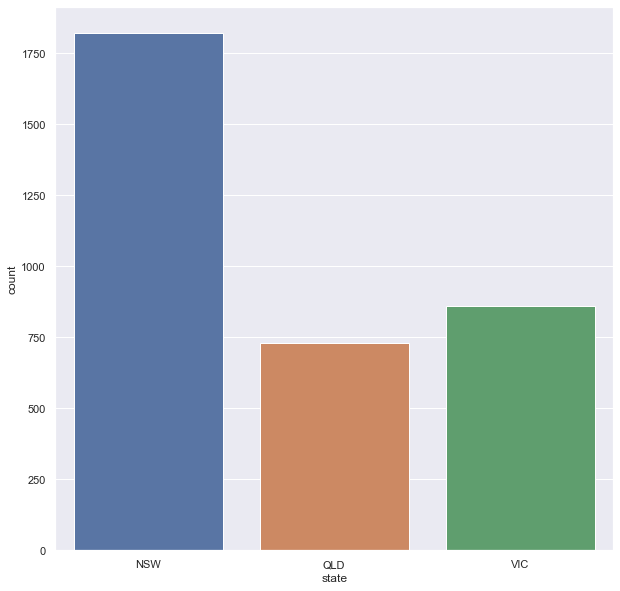

In [14]:
# state & sa4name
# NSW: New South Wales; QLD:Queensland ;VIC: Victoria
plt.figure(figsize=(10,10))
sns.countplot(new_customer['state'])
# SA4 analysis
print('Top5 most trans_count places: ')
print(new_customer.groupby(['sa4name']).agg({'trans_count':'count'}).nlargest(5,'trans_count'))
print('\nTop5 least trans_count places: ')
print(new_customer.groupby(['sa4name']).agg({'trans_count':'count'}).nsmallest(5,'trans_count'))

results:
1. About 50% of customers are from NSW (New South Wales).
2. From ABS website, we know that SA4 is related to the labor market, so we introduced the sa4name variable according to the postcode.
3. We list top5 most and least trans_count grouped by the state and sa4name, then compared them with the map. Then we found that customers who lives near the city center are more likely to buy bicycle.

### property_valuation

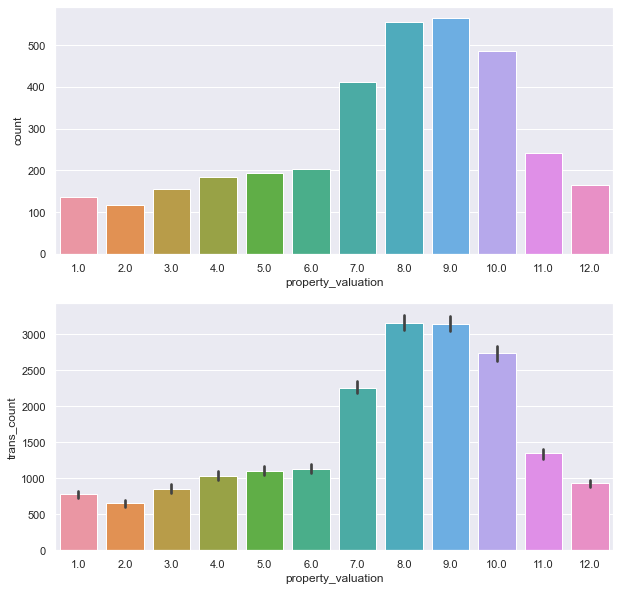

In [15]:
# property_valuation
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.countplot(new_customer['property_valuation'])
plt.subplot(2,1,2)
sns.barplot(x='property_valuation',y='trans_count',data=new_customer,estimator=np.sum)

results:
1. The property valuation of more than 50% of customers are between 7 to 10. And thesr customers also contributed more than 50% transactions.

### transaction summary

- product_id is not unique.
- profit & brand & product_line & product_class & product_size
- trans_count
- recency: whole & past 3 months

Total profit is:  10537893.48
Total customer is:  3410
Total number of transactions is:  19144

Past 3 months profit is:  2696105.67
Past 3 months customer is:  2613
Past 3 months number of transactions is:  4867

top10 sales goods: 
                                                         transaction_id
brand          product_line product_class product_size                
Solex          Standard     medium        medium                  1971
WeareA2B       Standard     medium        medium                  1873
OHM Cycles     Standard     medium        medium                  1036
Giant Bicycles Standard     medium        medium                   785
                                          large                    748
Trek Bicycles  Standard     medium        large                    655
Norco Bicycles Standard     medium        medium                   574
Giant Bicycles Standard     high          medium                   570
OHM Cycles     Standard     high          medium       

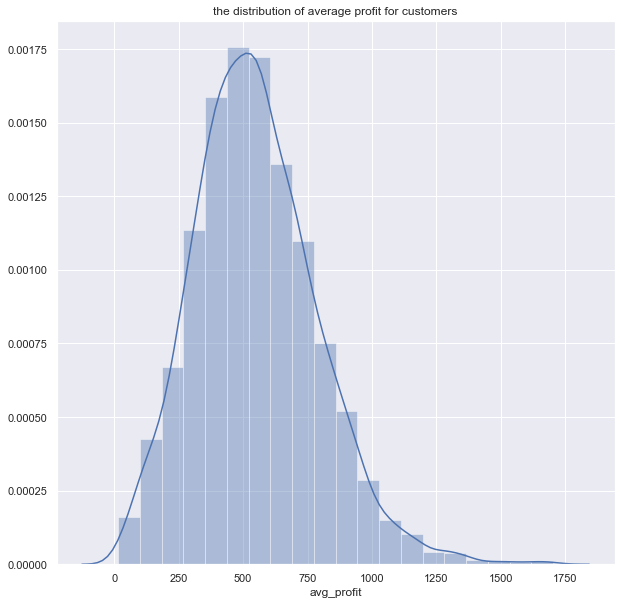

In [16]:
# profit
plt.figure(figsize=(10,10))
sns.distplot(new_customer['avg_profit'],bins=20)
plt.title('the distribution of average profit for customers')

# transaction summary
total_profit = transactions['profit'].sum()
print('Total profit is: ',round(total_profit,2))
total_customer = len(transactions['customer_id'].unique())
print('Total customer is: ',total_customer)
total_trans = transactions['transaction_id'].count()
print('Total number of transactions is: ',total_trans)
past3_profit = transactions[transactions['recency']<91]['profit'].sum()
print('\nPast 3 months profit is: ',round(past3_profit,2))
past3_customer = len(transactions[transactions['recency']<91]['customer_id'].unique())
print('Past 3 months customer is: ',past3_customer)
past3_trans = transactions[transactions['recency']<91]['transaction_id'].count()
print('Past 3 months number of transactions is: ',past3_trans)

# brand & product_line & product_class & product_size
trans_good = transactions.groupby(['brand','product_line','product_class','product_size']).agg({'transaction_id':'count','profit':'mean'})
#trans_good.rename({'transaction_id':'transaction_count','profit':'profit_mean'})
# top10 sale goods
print('\ntop10 sales goods: \n',trans_good.nlargest(10,'transaction_id')[['transaction_id']])
# top10 high profit goods - high margin product
print('\ntop10 high profit goods: \n',trans_good.nlargest(10,'profit')[['profit']])

# the ratio of customer with average of profit above 700
avgprofit_above700 = new_customer[new_customer['avg_profit']>699]
avgprofit_above700.head()
customer_ratio = avgprofit_above700['customer_id'].count() / new_customer['customer_id'].count()
profit_ratio = (avgprofit_above700['trans_count']*avgprofit_above700['avg_profit']).sum()/(new_customer['trans_count']*new_customer['avg_profit']).sum()
print('\nThe ratio of customer with ave_profit above 700: ',round(customer_ratio,2))
print('\nThe ratio of profit with ave_profit above 700: ',round(profit_ratio,2))

results:
1. More than 70% of customers had approved transactions in the past 3 months, and these customers contributed about 25% profit. 
2. Only about 25% of transactions happened in the past 3 months.
3. We have noticed that, the most popular product is Solex-Standard(class:medium, size:medium), and the highest profit product is WeareA2B-Touring(class:medium, size:large) in the last year.

# Model Development

- construct RFM model
- selected possible variables
- build regression model
- predict

In [86]:
# how to evaluate the customer value - try RFM model
# time period: past 3 months
past3months = new_customer[new_customer['min_recency']<91]
# min_recency: 1-5, 5 is most recently
past3months['r_score'] = pd.cut(past3months['min_recency'],bins=5,labels=[5,4,3,2,1],include_lowest=True)
# trans_count: 1-5, 5 is most bought
past3months['f_score'] = pd.cut(past3months['trans_count'],bins=5,labels=[1,2,3,4,5],include_lowest=True)
# avg_profit: 1-5, 5 is most spend, sum
past3months['sum_spend'] = past3months['trans_count'] * past3months['avg_profit']
past3months['m_score'] = pd.cut(past3months['sum_spend'],bins=5,labels=[1,2,3,4,5],include_lowest=True)
# rfm score and rank
past3months['r_score'] = past3months['r_score'].astype('int')
past3months['f_score'] = past3months['f_score'].astype('int')
past3months['m_score'] = past3months['m_score'].astype('int')
past3months['rfm'] = past3months['r_score']*100+new_customer['f_score']*10+new_customer['m_score']
past3months['rfm_rank'] = past3months['rfm'].rank(method='min',ascending=False)

In [87]:
# check the correlation between varibles
past3months['car'] = past3months['owns_car'].replace(['Yes','No'],[1,0])
past3months['postcode'] = past3months['postcode'].astype('object')
past3months.corr()

,past_3_years_bike_related_purchases,tenure,age,property_valuation,trans_count,min_recency,avg_profit,sum_spend,r_score,f_score,m_score,rfm,rfm_rank,wealth,car
past_3_years_bike_related_purchases,1.000000,-0.009235,-0.047019,0.012300,-0.020196,0.007814,0.018609,0.006531,-0.011177,-0.010431,-0.007007,-0.011765,0.010981,-0.034333,0.005269
tenure,-0.009235,1.000000,0.447339,-0.029650,-0.003613,0.012016,-0.001921,0.001387,-0.010205,-0.010107,-0.003783,-0.010766,0.012579,-0.004134,-0.023083
age,-0.047019,0.447339,1.000000,0.003281,-0.005941,0.003470,-0.021858,-0.020234,-0.006594,-0.019300,-0.014580,-0.007900,0.013393,-0.001612,-0.011023
property_valuation,0.012300,-0.029650,0.003281,1.000000,0.000513,0.007521,-0.010908,-0.009603,-0.003200,-0.002973,-0.011405,-0.003430,0.003777,-0.012949,0.040077
trans_count,-0.020196,-0.003613,-0.005941,0.000513,1.000000,-0.142149,-0.006303,0.691224,0.133011,0.950290,0.638814,0.197969,-0.313763,-0.000543,-0.022243
min_recency,0.007814,0.012016,0.003470,0.007521,-0.142149,1.000000,-0.028993,-0.117945,-0.978319,-0.146533,-0.105136,-0.976783,0.945118,-0.023461,-0.022554
avg_profit,0.018609,-0.001921,-0.021858,-0.010908,-0.006303,-0.028993,1.000000,0.656950,0.028655,-0.007817,0.605179,0.031289,-0.068220,0.017154,0.034299
sum_spend,0.006531,0.001387,-0.020234,-0.009603,0.691224,-0.117945,0.656950,1.000000,0.110213,0.660092,0.931771,0.157934,-0.265858,0.003884,0.007991
r_score,-0.011177,-0.010205,-0.006594,-0.003200,0.133011,-0.978319,0.028655,0.110213,1.000000,0.138377,0.095705,0.997606,-0.962955,0.022848,0.018420
f_score,-0.010431,-0.010107,-0.019300,-0.002973,0.950290,-0.146533,-0.007817,0.660092,0.138377,1.000000,0.609128,0.206384,-0.323673,-0.009115,-0.030080


From the correlation metrix, we can see that:
1. Age and tenure have position relationship, and the correlation coefficient is 0.4473.
2. There is no other significant correlation between other variables.
3. We only have 2613 samples, and need to try other methods to predict the high value customers, other than linear regression and random forest(overfitting).

# Clustering

Try to use clustering to cluster these customers

In [100]:
from sklearn.cluster import KMeans
rfm_seg = past3months[['min_recency','trans_count','sum_spend']]
clf = KMeans(n_clusters=5,random_state=0)
clf.fit(rfm_seg)
rfm_seg['cluster'] = clf.labels_

In [103]:
past3months['cluster']=rfm_seg['cluster']

In [104]:
past3months.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,bought_grouped,sum_spend,r_score,f_score,m_score,rfm,rfm_rank,wealth,car,cluster
customer_id,,,,,,,,,,,,,,,,,,,,,
1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,...,"(80, 100]",3018.09,5,4,2,542.0,106.0,1,1,4
5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,Yes,...,"(40, 60]",2394.94,5,2,2,522.0,416.0,2,1,4
6,Curr,Duckhouse,Male,35,1966-09-16,NaN,Retail,High Net Worth,N,Yes,...,"(20, 40]",3946.55,2,2,2,222.0,2084.0,3,1,0
8,Rod,Inder,Male,31,1962-03-30,Media Manager I,NaN,Mass Customer,N,No,...,"(20, 40]",7066.94,4,4,4,444.0,895.0,1,0,2
9,Mala,Lind,Female,97,1973-03-10,Business Systems Development Analyst,Argiculture,Affluent Customer,N,Yes,...,"(80, 100]",2353.11,1,2,1,122.0,2404.0,2,1,4


# High Value Customers???

In [105]:
# reference: excel_NewCustomerList
# build a condition and equation

# Tableau Dashboard

Use Tableau to build the dashboard and present it.

It is important to keep in mind the business context when presenting your findings:
 
- What are the trends in the underlying data?
- Which customer segment has the highest customer value?
- What do you propose should be Sprocket Central Pty Ltd ’s marketing and growth strategy?
- What additional external datasets may be useful to obtain greater insights into customer preferences and propensity to purchase the products?
- Specifically, your presentation should specify who Sprocket Central Pty Ltd’s marketing team should be targeting out of the new 1000 customer list as well as the broader market segment to reach out to. 